In [3]:
import sys
sys.path.append("...")
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [5]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [12]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host="clickhouse.xxxx.site", port=443,
    username="xxxx", password="xxxx",
    secure=True
)

print(client.command("SELECT 1"))

1


In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

OUT_DIR = Path("./outputs/data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TZ = TZ_LONDON

# You can override this later
N_USERS = 300

# London bounding box (same as you used before; adjust if needed)
LAT_MIN, LAT_MAX = 51.28, 51.69
LON_MIN, LON_MAX = -0.53, 0.24

# Base start date (use your previous baseline)
BASE_START = pd.Timestamp("2021-10-12 00:00:00")  # adjust if you want a different period

WIN_1W = (BASE_START, BASE_START + pd.Timedelta(days=7))
WIN_1M = (BASE_START, BASE_START + pd.Timedelta(days=30))
WIN_3M = (BASE_START, BASE_START + pd.Timedelta(days=90))

print("Windows:", WIN_1W, WIN_1M, WIN_3M)

Windows: (Timestamp('2021-10-12 00:00:00'), Timestamp('2021-10-19 00:00:00')) (Timestamp('2021-10-12 00:00:00'), Timestamp('2021-11-11 00:00:00')) (Timestamp('2021-10-12 00:00:00'), Timestamp('2022-01-10 00:00:00'))


In [16]:
# --------- parameters to tune ----------
CANDIDATES = 5000          # candidate pool size (5k is usually enough)
TH_NIGHT_SHARE = 0.80      # night dwell share inside London bbox
TH_STABILITY = 0.80        # night anchor stability threshold
# --------------------------------------

# Step A) sample candidates (random active users in 3M)
sql_candidates = f"""
SELECT userid
FROM src.trips_v1r0
PREWHERE start_time >= toDateTime('{WIN_3M[0]:%Y-%m-%d %H:%M:%S}')
    AND start_time <  toDateTime('{WIN_3M[1]:%Y-%m-%d %H:%M:%S}')
WHERE label != -1
GROUP BY userid
ORDER BY rand()
LIMIT {CANDIDATES}
"""
cand = client.query_df(sql_candidates)["userid"].astype(str).tolist()
print("Candidates:", len(cand))

# Step B) fetch stays for candidates (3M)
import time
import numpy as np
import pandas as pd
import clickhouse_connect

def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def fetch_stays_for_users_batched(
    start_dt, end_dt, users,
    batch_size=300,
    max_retries=3,
    sleep_sec=2.0,
):
    """
    Fetch stays for a list of users in batches to avoid HTTP 524 timeouts.
    Each batch uses a fresh client (avoids session lock).
    Returns a concatenated DataFrame.
    """
    all_blocks = []
    n_batches = int(np.ceil(len(users) / batch_size))
    t0 = time.time()

    for bi, batch_users in enumerate(chunk_list(users, batch_size), start=1):
        users_escaped = ",".join([f"'{u}'" for u in batch_users])

        sql = f"""
        WITH [{users_escaped}] AS uids
        SELECT
          userid AS user_id,
          start_time,
          end_time,
          coalesce(nullIf(o_h10,''), nullIf(d_h10,'')) AS hex_id,
          coalesce(d_lat, o_lat) AS lat,
          coalesce(d_lon, o_lon) AS lon
        FROM src.trips_v1r0
        PREWHERE start_time >= toDateTime('{start_dt:%Y-%m-%d %H:%M:%S}')
            AND start_time <  toDateTime('{end_dt:%Y-%m-%d %H:%M:%S}')
        WHERE label != -1
          AND has(uids, userid)
          AND coalesce(nullIf(o_h10,''), nullIf(d_h10,'')) != ''
        """

        ok = False
        for attempt in range(1, max_retries+1):
            try:
                client_local = clickhouse_connect.get_client(
                    host="clickhouse.adamzhou.site", port=443,
                    username="realtrips", password="0RYP2OGz",
                    secure=True
                )
                df = client_local.query_df(sql)

                # basic cleanup
                df["user_id"] = df["user_id"].astype(str)
                df["start_time"] = pd.to_datetime(df["start_time"])
                df["end_time"] = pd.to_datetime(df["end_time"])
                df["duration_min"] = (df["end_time"] - df["start_time"]).dt.total_seconds()/60.0
                df["hex_id"] = df["hex_id"].astype(str)
                df = df[df["duration_min"] > 0].copy()

                all_blocks.append(df)
                ok = True
                break

            except Exception as e:
                print(f"[Batch {bi}/{n_batches}] attempt {attempt}/{max_retries} failed: {type(e).__name__}: {e}")
                time.sleep(sleep_sec * attempt)

        if not ok:
            raise RuntimeError(f"Batch {bi}/{n_batches} failed after {max_retries} retries.")

        # progress
        elapsed = time.time() - t0
        rows = sum(len(x) for x in all_blocks)
        print(f"[Batch {bi}/{n_batches}] ok | rows so far={rows:,} | elapsed={elapsed:.1f}s")

    out = pd.concat(all_blocks, ignore_index=True) if all_blocks else pd.DataFrame()
    return out

cand_stays = fetch_stays_for_users_batched(WIN_3M[0], WIN_3M[1], cand, batch_size=200)
print("Fetched stays:", len(cand_stays), "users:", cand_stays["user_id"].nunique())

# Step C) compute residency scores and select London residents cohort
def compute_residency_scores(stays_df):
    d = stays_df.copy()
    d["date"] = d["start_time"].dt.date

    # night definition by midpoint
    mid = d["start_time"] + pd.to_timedelta(d["duration_min"]/2, unit="m")
    hh = mid.dt.hour + mid.dt.minute/60.0
    night = (hh >= 20) | (hh < 6)
    d["night_dwell"] = np.where(night, d["duration_min"], 0.0)

    # bbox membership using lat/lon
    in_bbox = d["lat"].between(LAT_MIN, LAT_MAX) & d["lon"].between(LON_MIN, LON_MAX)
    d["night_in_bbox_dwell"] = np.where(night & in_bbox, d["duration_min"], 0.0)

    g = d.groupby("user_id", as_index=False).agg(
        night_dwell=("night_dwell","sum"),
        night_in_bbox=("night_in_bbox_dwell","sum"),
    )
    g["night_in_bbox_share"] = g["night_in_bbox"] / g["night_dwell"].replace(0, np.nan)
    g["night_in_bbox_share"] = g["night_in_bbox_share"].fillna(0.0)

    # night anchor stability (mode over days)
    dn = d.groupby(["user_id","date","hex_id"], as_index=False)["night_dwell"].sum()
    dn = dn[dn["night_dwell"] > 0].sort_values(["user_id","date","night_dwell"], ascending=[True,True,False])
    top_night = dn.drop_duplicates(["user_id","date"])[["user_id","date","hex_id"]]

    def stab(user_df):
        mode_hex = user_df["hex_id"].value_counts().idxmax()
        return (user_df["hex_id"] == mode_hex).mean()

    stab_s = top_night.groupby("user_id").apply(stab).rename("night_anchor_stability").reset_index()

    # home hex point: take the hex with max night_dwell, and its median lat/lon
    home_hex = dn.sort_values(["user_id","night_dwell"], ascending=[True,False]).drop_duplicates("user_id")[["user_id","hex_id"]]
    home_pts = d.merge(home_hex, on=["user_id","hex_id"], how="inner") \
                .groupby("user_id", as_index=False).agg(home_lat=("lat","median"), home_lon=("lon","median"))
    home_pts["home_in_bbox"] = home_pts["home_lat"].between(LAT_MIN, LAT_MAX) & home_pts["home_lon"].between(LON_MIN, LON_MAX)

    out = g.merge(stab_s, on="user_id", how="left").merge(home_pts, on="user_id", how="left")
    out["night_anchor_stability"] = out["night_anchor_stability"].fillna(0.0)
    out["home_in_bbox"] = out["home_in_bbox"].fillna(False)
    return out

scores = compute_residency_scores(cand_stays)

print("\nResidency score summary:")
print(scores[["night_in_bbox_share","night_anchor_stability","home_in_bbox"]].describe())

resident = scores[
    (scores["home_in_bbox"] == True) &
    (scores["night_in_bbox_share"] >= TH_NIGHT_SHARE) &
    (scores["night_anchor_stability"] >= TH_STABILITY)
].copy()

print("\nResidents found:", len(resident))
if len(resident) < N_USERS:
    print("WARNING: residents < N_USERS. Consider increasing CANDIDATES or relaxing thresholds.")

resident_users = resident.sort_values(
    ["night_anchor_stability","night_in_bbox_share"], ascending=False
)["user_id"].astype(str).tolist()

# cohort_users = resident_users[:N_USERS]
# print("Final cohort size:", len(cohort_users))
# print("Top 5 users:", cohort_users[:5])

# # save cohort
# cohort_path = OUT_DIR / "uk_london_cohort_users_300.csv"
# pd.Series(cohort_users).to_csv(cohort_path, index=False, header=False)
# print("Saved cohort:", cohort_path)

Candidates: 5000
[Batch 1/25] ok | rows so far=35,197 | elapsed=34.9s
[Batch 2/25] ok | rows so far=70,463 | elapsed=69.2s
[Batch 3/25] ok | rows so far=102,735 | elapsed=103.4s
[Batch 4/25] ok | rows so far=134,226 | elapsed=137.7s
[Batch 5/25] ok | rows so far=169,092 | elapsed=172.7s
[Batch 6/25] ok | rows so far=204,095 | elapsed=224.0s
[Batch 7/25] ok | rows so far=234,351 | elapsed=263.2s
[Batch 8/25] ok | rows so far=265,690 | elapsed=300.7s
[Batch 9/25] ok | rows so far=298,024 | elapsed=337.9s
[Batch 10/25] ok | rows so far=329,502 | elapsed=375.0s
[Batch 11/25] ok | rows so far=365,869 | elapsed=412.4s
[Batch 12/25] ok | rows so far=394,907 | elapsed=448.4s
[Batch 13/25] ok | rows so far=429,433 | elapsed=484.9s
[Batch 14/25] ok | rows so far=460,741 | elapsed=521.3s
[Batch 15/25] ok | rows so far=495,503 | elapsed=557.9s
[Batch 16/25] ok | rows so far=525,228 | elapsed=593.6s
[Batch 17/25] ok | rows so far=558,705 | elapsed=628.1s
[Batch 18/25] ok | rows so far=593,973 | ela

In [22]:
N_FINAL = 300
N_CAND_RESIDENT = 1200  # 先留多一些

resident_users = resident.sort_values(
    ["night_anchor_stability","night_in_bbox_share"], ascending=False
)["user_id"].astype(str).tolist()

resident_pool = resident_users[:N_CAND_RESIDENT]
print("Resident pool size:", len(resident_pool))

Resident pool size: 504


In [23]:
def count_stays_in_window(client, start_dt, end_dt, users):
    users_escaped = ",".join([f"'{u}'" for u in users])
    sql = f"""
    WITH [{users_escaped}] AS uids
    SELECT
      userid AS user_id,
      count() AS n_stays
    FROM src.trips_v1r0
    PREWHERE start_time >= toDateTime('{start_dt:%Y-%m-%d %H:%M:%S}')
        AND start_time <  toDateTime('{end_dt:%Y-%m-%d %H:%M:%S}')
    WHERE label != -1
      AND has(uids, userid)
      AND coalesce(nullIf(o_h10,''), nullIf(d_h10,'')) != ''
    GROUP BY userid
    """
    return client.query_df(sql)

MIN_PER_WEEK = 10
thr_1w = MIN_PER_WEEK * 1
thr_1m = MIN_PER_WEEK * 4
thr_3m = MIN_PER_WEEK * 12

c1 = count_stays_in_window(client, WIN_1W[0], WIN_1W[1], resident_pool).set_index("user_id")["n_stays"]
c2 = count_stays_in_window(client, WIN_1M[0], WIN_1M[1], resident_pool).set_index("user_id")["n_stays"]
c3 = count_stays_in_window(client, WIN_3M[0], WIN_3M[1], resident_pool).set_index("user_id")["n_stays"]

# align to resident_pool index
idx = pd.Index(resident_pool, name="user_id")
c1 = c1.reindex(idx).fillna(0).astype(int)
c2 = c2.reindex(idx).fillna(0).astype(int)
c3 = c3.reindex(idx).fillna(0).astype(int)

ok = (c1 >= thr_1w) & (c2 >= thr_1m) & (c3 >= thr_3m)
eligible = idx[ok].tolist()
print("Eligible users:", len(eligible))

cohort_users = eligible[:N_FINAL]
print("Final cohort size:", len(cohort_users))

Eligible users: 231
Final cohort size: 231


In [24]:
def export_stays_for_users_batched_to_parquet(client, start_dt, end_dt, users, out_parquet,
                                              batch_size=200):
    blocks=[]
    users = list(map(str, users))
    n_batches = int(np.ceil(len(users)/batch_size))

    for bi in range(n_batches):
        batch = users[bi*batch_size:(bi+1)*batch_size]
        users_escaped = ",".join([f"'{u}'" for u in batch])

        sql = f"""
        WITH [{users_escaped}] AS uids
        SELECT
          userid AS user_id,
          start_time,
          end_time,
          activity_duration,
          coalesce(nullIf(o_h10,''), nullIf(d_h10,'')) AS hex_id,
          coalesce(d_lat, o_lat) AS lat,
          coalesce(d_lon, o_lon) AS lon
        FROM src.trips_v1r0
        PREWHERE start_time >= toDateTime('{start_dt:%Y-%m-%d %H:%M:%S}')
            AND start_time <  toDateTime('{end_dt:%Y-%m-%d %H:%M:%S}')
        WHERE label != -1
          AND has(uids, userid)
          AND coalesce(nullIf(o_h10,''), nullIf(d_h10,'')) != ''
        ORDER BY userid, start_time
        """
        df = client.query_df(sql)
        blocks.append(df)
        print(f"[{bi+1}/{n_batches}] fetched rows={len(df):,}")

    out = pd.concat(blocks, ignore_index=True) if blocks else pd.DataFrame()
    out.to_parquet(out_parquet, index=False)
    print("Saved:", out_parquet, "| rows:", len(out), "| users:", out["user_id"].nunique())
    return out

# Output file names (encode cohort size for clarity)
p1w = OUT_DIR / f"uk_london_stays_1w_u{len(cohort_users)}.parquet"
p1m = OUT_DIR / f"uk_london_stays_1m_u{len(cohort_users)}.parquet"
p3m = OUT_DIR / f"uk_london_stays_3m_u{len(cohort_users)}.parquet"

uk_1w_raw = export_stays_for_users_batched_to_parquet(client, WIN_1W[0], WIN_1W[1], cohort_users, p1w, batch_size=200)
uk_1m_raw = export_stays_for_users_batched_to_parquet(client, WIN_1M[0], WIN_1M[1], cohort_users, p1m, batch_size=200)
uk_3m_raw = export_stays_for_users_batched_to_parquet(client, WIN_3M[0], WIN_3M[1], cohort_users, p3m, batch_size=200)

[1/2] fetched rows=5,107
[2/2] fetched rows=839
Saved: /Users/pang/Codes/GISRUK/outputs/data/uk_london_stays_1w_u231.parquet | rows: 5946 | users: 231
[1/2] fetched rows=21,487
[2/2] fetched rows=3,295
Saved: /Users/pang/Codes/GISRUK/outputs/data/uk_london_stays_1m_u231.parquet | rows: 24782 | users: 231
[1/2] fetched rows=53,692
[2/2] fetched rows=7,831
Saved: /Users/pang/Codes/GISRUK/outputs/data/uk_london_stays_3m_u231.parquet | rows: 61523 | users: 231


In [10]:
def load_uk_stays(path):
    d = pd.read_parquet(path)
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"])
    d["end_time"] = pd.to_datetime(d["end_time"])
    d["duration_min"] = (d["end_time"] - d["start_time"]).dt.total_seconds()/60.0
    d["hex_id"] = d["hex_id"].astype(str).replace({"": np.nan, "nan": np.nan})
    d = d.dropna(subset=["hex_id"]).copy()
    d = d[d["duration_min"] > 0].copy()
    return d

p1w = OUT_DIR / f"uk_london_stays_1w_u{231}.parquet"
p1m = OUT_DIR / f"uk_london_stays_1m_u{231}.parquet"
p3m = OUT_DIR / f"uk_london_stays_3m_u{231}.parquet"

uk_1w = load_uk_stays(p1w)
uk_1m = load_uk_stays(p1m)
uk_3m = load_uk_stays(p3m)

for name, d in [("1W", uk_1w), ("1M", uk_1m), ("3M", uk_3m)]:
    print("\n==", name, "==")
    print("rows:", len(d), "users:", d["user_id"].nunique(), "days:", d["start_time"].dt.date.nunique())
    print(d["duration_min"].describe(percentiles=[0.5,0.9,0.95,0.99]))
    in_bbox = ((d["lat"].between(LAT_MIN, LAT_MAX)) & (d["lon"].between(LON_MIN, LON_MAX))).mean()
    print("Share stays inside London bbox:", float(in_bbox))


== 1W ==
rows: 5946 users: 231 days: 7
count    5946.000000
mean      310.345885
std       459.073865
min         5.000000
50%        91.475000
90%       941.075000
95%      1135.166667
99%      1988.370833
max      7145.866667
Name: duration_min, dtype: float64
Share stays inside London bbox: 0.937773292970064

== 1M ==
rows: 24782 users: 231 days: 30
count    24782.000000
mean       314.359612
std        481.901832
min          5.000000
50%         85.525000
90%        954.385000
95%       1189.598333
99%       2284.498000
max       7145.866667
Name: duration_min, dtype: float64
Share stays inside London bbox: 0.9264788959728836

== 3M ==
rows: 61523 users: 231 days: 81
count    61523.000000
mean       324.048824
std        502.828362
min          5.000000
50%         91.333333
90%        966.156667
95%       1207.098333
99%       2389.771667
max      15990.683333
Name: duration_min, dtype: float64
Share stays inside London bbox: 0.9337646083578499


In [26]:
uk_1w_reg = regularity_report(uk_1w, name=f"LONDON_1W_u{len(cohort_users)}")
uk_1m_reg = regularity_report(uk_1m, name=f"LONDON_1M_u{len(cohort_users)}")
uk_3m_reg = regularity_report(uk_3m, name=f"LONDON_3M_u{len(cohort_users)}")

summary = pd.DataFrame([
    summarize_reg(f"LONDON_1W_u{len(cohort_users)}", uk_1w, uk_1w_reg),
    summarize_reg(f"LONDON_1M_u{len(cohort_users)}", uk_1m, uk_1m_reg),
    summarize_reg(f"LONDON_3M_u{len(cohort_users)}", uk_3m, uk_3m_reg),
])
summary_path = Path("/Users/pang/Codes/GISRUK/outputs/tables") / f"uk_extraction_summary_u{len(cohort_users)}.csv"
summary_path.parent.mkdir(parents=True, exist_ok=True)
summary.to_csv(summary_path, index=False)
print("Saved:", summary_path)
summary


===== LONDON_1W_u231 regularity report =====
rows: 5946 users: 231

===== LONDON_1M_u231 regularity report =====
rows: 24782 users: 231

===== LONDON_3M_u231 regularity report =====
rows: 61523 users: 231
Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_extraction_summary_u231.csv


,dataset,users,calendar_days,stays,user_days_med,stays/user/day_med,stays/user/day_p90,top1_share_med,top3_share_med,unique_hex_med,max_visit_days_med,night_stability_med
0,LONDON_1W_u231,231,7,5946,7.0,3.714286,6.000000,0.839904,0.979966,8.0,6.0,1.000000
1,LONDON_1M_u231,231,30,24782,27.0,3.700000,5.833333,0.832221,0.961501,23.0,26.0,0.960000
2,LONDON_3M_u231,231,81,61523,70.0,3.670886,5.500000,0.841902,0.955865,44.0,67.0,0.933333


Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_quick_patterns_by_dow_u231.png


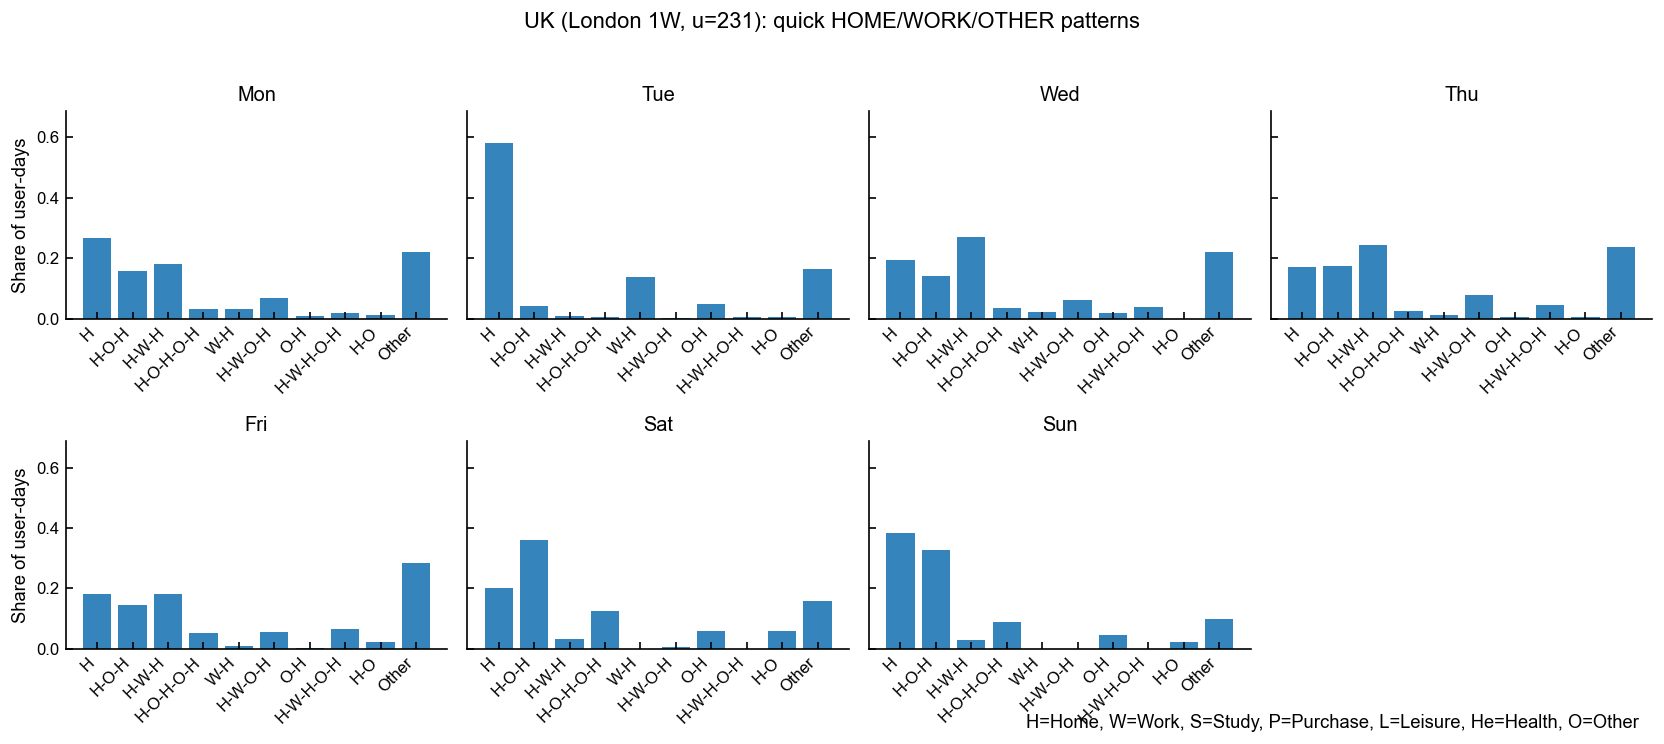

(pattern2         H     H-O-H     H-W-H  H-O-H-O-H       W-H   H-W-O-H  \
 dow                                                                     
 0         0.266968  0.158371  0.180995   0.031674  0.031674  0.067873   
 1         0.580336  0.043165  0.009592   0.004796  0.136691  0.002398   
 2         0.192982  0.140351  0.271930   0.035088  0.021930  0.061404   
 3         0.171053  0.175439  0.245614   0.026316  0.013158  0.078947   
 4         0.182609  0.143478  0.182609   0.052174  0.008696  0.056522   
 5         0.202703  0.360360  0.031532   0.126126  0.000000  0.004505   
 6         0.383886  0.327014  0.028436   0.090047  0.000000  0.000000   
 
 pattern2       O-H  H-W-H-O-H       H-O     Other  
 dow                                                
 0         0.009050   0.018100  0.013575  0.221719  
 1         0.047962   0.004796  0.004796  0.165468  
 2         0.017544   0.039474  0.000000  0.219298  
 3         0.004386   0.043860  0.004386  0.236842  
 4         0.0

In [28]:
# --- Pattern helpers (copied from notebook 01; keep in notebook for easy iteration) ---

from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import ABBR, TZ_LONDON

def collapse_consecutive(labels):
    out=[]
    for x in labels:
        if len(out)==0 or x!=out[-1]:
            out.append(x)
    return out

def build_daily_patterns(stays_df, label_col="y_true", min_dur_min=10, require_home_sandwich=False,
                         tz=TZ_LONDON, assume_utc_if_naive=True):
    """
    Build daily activity patterns (one pattern per user-day).
    Uses DST-safe to_local_time_series and splits cross-midnight intervals.
    """
    d = stays_df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()
    d = d[d["duration_min"] > 0].copy()

    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()

    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        if require_home_sandwich and not (labs2[0]=="HOME" and labs2[-1]=="HOME"):
            continue
        patt = "-".join([ABBR[x] for x in labs2])
        rows.append((u, date, int(g["dow"].iloc[0]), patt))
    return pd.DataFrame(rows, columns=["user_id","date","dow","pattern"])

def select_patterns_by_coverage(patterns_df, coverage=0.90, max_n=200, min_count=10):
    vc = patterns_df["pattern"].value_counts()
    vc = vc[vc >= min_count]
    cum = vc.cumsum() / vc.sum()
    selected = vc.index[cum <= coverage].tolist()
    if len(selected) == 0:
        selected = vc.head(min(max_n, len(vc))).index.tolist()
    else:
        selected = selected[:max_n]
    return selected

def plot_patterns_by_dow_small_multiples(patterns_df, coverage=0.90, max_n=12, min_count=10,
                                        title="Daily activity patterns by day-of-week",
                                        outpath=None):
    apply_nature_style()
    dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

    keep = select_patterns_by_coverage(patterns_df, coverage=coverage, max_n=200, min_count=min_count)
    tmp = patterns_df.copy()
    tmp["pattern2"] = tmp["pattern"].where(tmp["pattern"].isin(keep), other="Other")

    global_counts = tmp["pattern2"].value_counts()
    ordered = global_counts.index.tolist()
    top_order = [p for p in ordered if p != "Other"][:max_n]
    if "Other" in ordered:
        top_order = top_order + ["Other"]

    tab = tmp.groupby(["dow","pattern2"]).size().unstack(fill_value=0).reindex(index=range(7), fill_value=0)
    tab = tab.reindex(columns=top_order, fill_value=0)
    share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharey=True)
    axes = axes.flatten()
    x = np.arange(len(top_order))

    for d in range(7):
        ax = axes[d]
        ax.bar(x, share.loc[d].values, alpha=0.9)
        ax.set_title(dow_names[d])
        ax.set_ylim(0, min(1.0, float(share.values.max())*1.15 + 0.02))
        ax.tick_params(direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xticks(x)
        ax.set_xticklabels(top_order, rotation=45, ha="right")
        if d % 4 == 0:
            ax.set_ylabel("Share of user-days")

    axes[7].axis("off")
    fig.suptitle(title, y=1.02)

    legend_text = "H=Home, W=Work, S=Study, P=Purchase, L=Leisure, He=Health, O=Other"
    fig.text(0.98, 0.02, legend_text, ha="right", va="bottom", fontsize=11)
    fig.subplots_adjust(hspace=0.40, wspace=0.05)

    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
        print("Saved:", outpath)
    plt.show()
    plt.close(fig)

    return share, top_order

def quick_label_hw_other(stays_df):
    hs = compute_user_hex_stats(stays_df)
    anchors = infer_home_work_anchors(hs)
    home_lookup = dict(zip(anchors["user_id"], anchors["home_hex"]))
    work_lookup = dict(zip(anchors["user_id"], anchors["work_hex"]))

    d = stays_df.copy()
    d["y_true"] = "OTHER"
    d.loc[d["hex_id"].astype(str) == d["user_id"].map(home_lookup).astype(str), "y_true"] = "HOME"
    d.loc[d["hex_id"].astype(str) == d["user_id"].map(work_lookup).astype(str), "y_true"] = "WORK"
    return d

uk_1w_q = quick_label_hw_other(uk_1w)

# reuse pattern functions from notebook 01 (you already have them there).
# simplest: copy your build_daily_patterns + plot_patterns_by_dow_small_multiples cells into this notebook too.

patterns_uk = build_daily_patterns(uk_1w_q, label_col="y_true", min_dur_min=10, require_home_sandwich=False)

fig_dir = Path("/Users/pang/Codes/GISRUK/outputs/figures")
fig_dir.mkdir(parents=True, exist_ok=True)
plot_patterns_by_dow_small_multiples(
    patterns_uk,
    coverage=0.90,
    max_n=12,
    min_count=10,
    title=f"UK (London 1W, u={len(cohort_users)}): quick HOME/WORK/OTHER patterns",
    outpath=str(fig_dir / f"uk_quick_patterns_by_dow_u{len(cohort_users)}.png")
)

In [1]:
def compute_gap_minutes(stays_df, tz="Europe/London", assume_utc_if_naive=True):
    d = stays_df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d = d.sort_values(["user_id","start_time"]).copy()

    d["prev_end"] = d.groupby("user_id")["end_time"].shift(1)
    d["gap_min"] = (d["start_time"] - d["prev_end"]).dt.total_seconds()/60.0
    d = d.dropna(subset=["gap_min"]).copy()

    # gap could be negative if overlaps exist (data issue)
    return d

In [11]:
def gap_report(stays_df, name):
    g = compute_gap_minutes(stays_df)
    gap = g["gap_min"].values

    neg_rate = float((gap < 0).mean())
    zeroish_rate = float((gap <= 1e-6).mean())
    gt_1h = float((gap > 60).mean())
    gt_6h = float((gap > 360).mean())
    gt_8h = float((gap > 480).mean())
    gt_12h = float((gap > 720).mean())
    gt_24h = float((gap > 1440).mean())

    q = np.quantile(gap, [0.5, 0.8, 0.9, 0.95, 0.99])

    print(f"\n== {name} gap report ==")
    print("rows:", len(g), "users:", g["user_id"].nunique())
    print("neg_gap_rate:", neg_rate, "zero_gap_rate:", zeroish_rate)
    print("P(gap>1h):", gt_1h, "P>6h:", gt_6h, "P>8h:", gt_8h, "P>12h:", gt_12h, "P>24h:", gt_24h)
    print("gap quantiles (min): p50,p80,p90,p95,p99 =", q)

# Example (use your UK dataframes)
gap_report(uk_1w, "UK 1W")
gap_report(uk_1m, "UK 1M")
gap_report(uk_3m, "UK 3M")


== UK 1W gap report ==
rows: 5715 users: 231
neg_gap_rate: 0.0 zero_gap_rate: 0.0
P(gap>1h): 0.2678915135608049 P>6h: 0.026771653543307086 P>8h: 0.022922134733158354 P>12h: 0.013648293963254593 P>24h: 0.006649168853893263
gap quantiles (min): p50,p80,p90,p95,p99 = [ 33.56666667  72.53333333 111.19666667 200.55833333 911.03666667]

== UK 1M gap report ==
rows: 24551 users: 231
neg_gap_rate: 0.0 zero_gap_rate: 0.0
P(gap>1h): 0.2647142682579121 P>6h: 0.03018206997678302 P>8h: 0.02578306382632072 P>12h: 0.017107246140686733 P>24h: 0.009734837684819355
gap quantiles (min): p50,p80,p90,p95,p99 = [  33.61666667   73.53333333  116.83333333  197.725      1317.6       ]

== UK 3M gap report ==
rows: 61292 users: 231
neg_gap_rate: 0.0 zero_gap_rate: 0.0
P(gap>1h): 0.2708510082881942 P>6h: 0.03432748156366247 P>8h: 0.028519219473993343 P>12h: 0.01977419565359264 P>24h: 0.012350714612021144
gap quantiles (min): p50,p80,p90,p95,p99 = [  33.98333333   75.28333333  121.815       222.77083333 1496.583